<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Interest Rate Swaps

*Very nascent*.

Interest rate swaps are a first step towards including **rate-sensitive instruments** in the modeling and valuation spectrum of DX Analytics. The model used in the following is the **square-root diffusion process** by Cox-Ingersoll-Ross (1985). Data used are UK/London OIS and Libor rates.

In [1]:
import dx
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

## OIS Data & Discounting

We start by importing **OIS term structure data** (source: http://www.bankofengland.co.uk) for risk-free discounting. We also adjust the data structure somewhat for our purposes.

In [2]:
# UK OIS Spot Rates Yield Curve
oiss = pd.read_excel('data/ukois09.xls', 'oiss')
# use years as index
oiss = oiss.set_index('years')
# del oiss['years']

In [3]:
# only date information for columns, no time
oiss.columns = [d.date() for d in oiss.columns]

In [4]:
oiss.tail()

,2014-10-01,2014-10-02,2014-10-03,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,2014-10-13,2014-10-14,2014-10-15,2014-10-16
years,,,,,,,,,,,,
4.666667,1.550947,1.525838,1.570203,1.533901,1.479044,1.445234,1.436023,1.409962,1.337567,1.283932,1.063205,1.234125
4.750000,1.563661,1.538616,1.583198,1.546459,1.491152,1.457593,1.448627,1.422015,1.349782,1.296052,1.074773,1.246277
4.833333,1.576142,1.551158,1.595952,1.558789,1.503050,1.469768,1.461040,1.433887,1.361832,1.308025,1.086254,1.258307
4.916667,1.588400,1.563474,1.608472,1.570898,1.514746,1.481764,1.473269,1.445585,1.373724,1.319859,1.097650,1.270219
5.000000,1.600442,1.575572,1.620768,1.582794,1.526247,1.493588,1.485320,1.457116,1.385461,1.331557,1.108962,1.282014


Next we replace the **year fraction index** by a **DatetimeIndex**.

In [5]:
# generate time index given input data
# starting date + 59 months
date = oiss.columns[-1]
index = pd.date_range(date, periods=60, freq='M') # , tz='GMT')
index = [d.replace(day=date.day) for d in index]
index = pd.DatetimeIndex(index)
oiss.index = index

Let us have a look at the **most current data**, i.e. the term structure, of the data set.

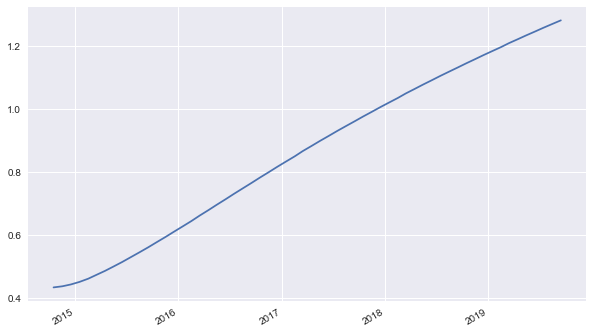

In [6]:
oiss.iloc[:, -1].plot(figsize=(10, 6))

This data is used to instantiate a `deterministic_short_rate` **model for risk-neutral discounting** purposes.

In [7]:
# generate deterministic short rate model based on UK OIS curve
ois = dx.deterministic_short_rate('ois', list(zip(oiss.index, oiss.iloc[:, -1].values / 100)))

In [8]:
# example dates and corresponding discount factors
dr = pd.date_range('2015-1', periods=4, freq='6m').to_pydatetime()
ois.get_discount_factors(dr)[::-1]

([0.989825148692371, 0.9922754901627036, 0.9956237774158325, 1.0],
 array([datetime.datetime(2015, 1, 31, 0, 0),
        datetime.datetime(2015, 7, 31, 0, 0),
        datetime.datetime(2016, 1, 31, 0, 0),
        datetime.datetime(2016, 7, 31, 0, 0)], dtype=object))

## Libor Market Data

We want to model a **3 month Libor-based interest rate swap**. To this end, we need Libor term structure data, i.e. forward rates in this case (source: http://www.bankofengland.co.uk), to calibrate the  valuation to. The data importing and adjustments are the same as before.

In [9]:
# UK Libor foward rates
libf = pd.read_excel('data/ukblc05.xls', 'fwds')
# use years as index
libf = libf.set_index('years')

In [10]:
# only date information for columns, no time
libf.columns = [d.date() for d in libf.columns]

In [11]:
libf.tail()

,2014-10-01,2014-10-02,2014-10-03,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,2014-10-13,2014-10-14,2014-10-15,2014-10-16
years,,,,,,,,,,,,
4.666667,2.722915,2.686731,2.678433,2.681385,2.639166,2.542012,2.528768,2.489063,2.470154,2.349732,2.372435,2.157431
4.750000,2.733588,2.697887,2.690366,2.692824,2.650841,2.554583,2.543066,2.502357,2.483842,2.366052,2.387671,2.176186
4.833333,2.744126,2.708848,2.702083,2.704147,2.662380,2.567071,2.557216,2.515531,2.497446,2.382298,2.402829,2.194784
4.916667,2.754540,2.719634,2.713604,2.715368,2.673794,2.579486,2.571229,2.528592,2.510973,2.398468,2.417915,2.213221
5.000000,2.764842,2.730264,2.724949,2.726501,2.685095,2.591835,2.585117,2.541548,2.524432,2.414562,2.432939,2.231493


In [12]:
# generate time index given input data
# starting date + 59 months
date = libf.columns[-1]
index = pd.date_range(date, periods=60, freq='M')  # , tz='GMT')
index = [d.replace(day=date.day) for d in index]
index = pd.DatetimeIndex(index)
libf.index = index

And the short end of the **Libor term sturcture** visualized.

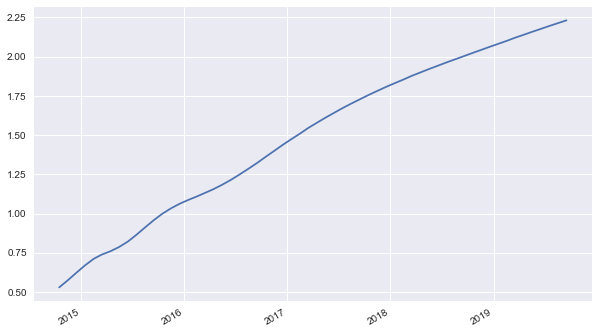

In [13]:
libf.iloc[:, -1].plot(figsize=(10, 6))

## Model Calibration

Next, equipped with the Libor data, we calibrate the **square-root diffusion short rate model**. A bit of data preparation:

In [14]:
t = libf.index.to_pydatetime()
f = libf.iloc[:, -1].values / 100
initial_value = 0.005

A **mean-squared error (MSE)** function to be minimized during calibration.

In [15]:
def srd_forward_error(p0):
    global initial_value, f, t
    if p0[0] < 0 or p0[1] < 0 or p0[2] < 0:
        return 100
    f_model = dx.srd_forwards(initial_value, p0, t)
    MSE = np.sum((f - f_model) ** 2) / len(f)
    return MSE

And the **calibration** itself.

In [16]:
from scipy.optimize import fmin

In [17]:
opt = fmin(srd_forward_error, (1.0, 0.7, 0.2),
           maxiter=1000, maxfun=1000)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 371
         Function evaluations: 649


The **optimal parameters** (kappa, theta, sigma) are:

In [18]:
opt

array([0.00544441, 1.80697228, 0.23689443])

The **model fit** is not too bad in this case.

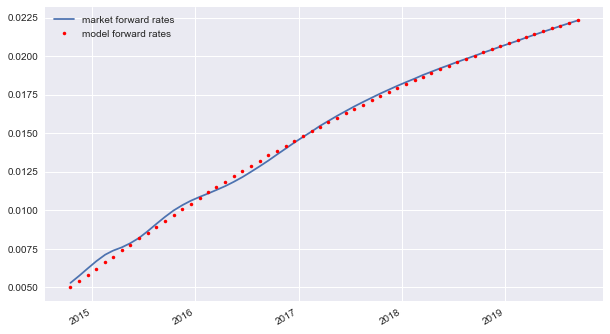

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(t, f, label='market forward rates')
plt.plot(t, dx.srd_forwards(initial_value, opt, t), 'r.', label='model forward rates')
plt.gcf().autofmt_xdate(); plt.legend(loc=0)

## Floating Rate Modeling

The optimal parameters from the calibration are used to model the **floating rate (3m Libor rate)**.

In [20]:
# market environment
me_srd = dx.market_environment('me_srd', dt.datetime(2014, 10, 16))

In [21]:
# square-root diffusion
me_srd.add_constant('initial_value', 0.02)
me_srd.add_constant('kappa', opt[0]) 
me_srd.add_constant('theta', opt[1])
me_srd.add_constant('volatility', opt[2])
me_srd.add_curve('discount_curve', ois)
  # OIS discounting object
me_srd.add_constant('currency', 'EUR')
me_srd.add_constant('paths', 10000)
me_srd.add_constant('frequency', 'w')
me_srd.add_constant('starting_date', me_srd.pricing_date)
me_srd.add_constant('final_date', dt.datetime(2020, 12, 31))

In [22]:
srd = dx.square_root_diffusion('srd', me_srd)

Let us have a look at some **simulated rate paths**.

In [23]:
paths = srd.get_instrument_values()

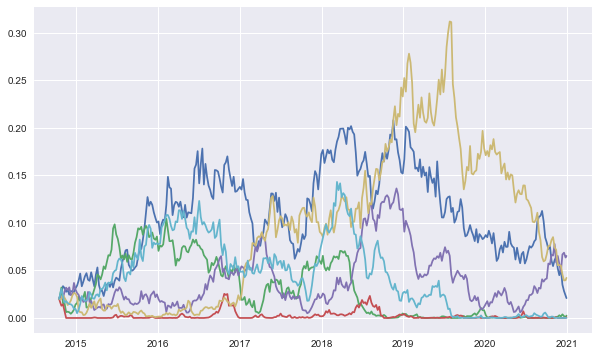

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(srd.time_grid, paths[:, :6])

## Interest Rate Swap

Finally, we can model the **interest rate swap** itself.

### Modeling

First, the market environment with all the **parameters** needed.

In [25]:
# market environment for the IRS
me_irs = dx.market_environment('irs', me_srd.pricing_date)
me_irs.add_constant('fixed_rate', 0.01)
me_irs.add_constant('trade_date', me_srd.pricing_date)
me_irs.add_constant('effective_date', me_srd.pricing_date)
me_irs.add_constant('payment_date', dt.datetime(2014, 12, 27))
me_irs.add_constant('payment_day', 27)
me_irs.add_constant('termination_date', me_srd.get_constant('final_date'))
me_irs.add_constant('currency', 'EUR')
me_irs.add_constant('notional', 1000000)
me_irs.add_constant('tenor', '6m')
me_irs.add_constant('counting', 'ACT/360')
# discount curve from mar_env of floating rate

The instantiation of the **valuation object**.

In [26]:
irs = dx.interest_rate_swap('irs', srd, me_irs)

### Valuation

The **present value** of the interest rate swap given the assumption, in particular, of the fixed rate.

In [27]:
%time irs.present_value(fixed_seed=True)

CPU times: user 198 ms, sys: 82 ms, total: 280 ms
Wall time: 299 ms


482804.6280483039

You can also generate a **full output of all present values** per simulation path.

In [28]:
irs.present_value(full=True).iloc[:, :6]

,0,1,2,3,4,5
2014-12-27,20919.908406,3765.545880,-10000.000000,20447.662984,15671.171542,-461.905549
2015-06-27,27796.391566,67649.371268,-7952.865109,21069.238749,6547.642190,56254.997722
2015-12-27,72797.267752,65085.851729,-9495.534310,7184.517383,-6249.109421,72603.409748
2016-06-27,146587.773739,60725.900678,-9450.695252,10630.874710,1457.279233,96390.826927
2016-12-27,112006.856512,11685.574401,-9365.011855,36777.060898,40752.233786,42437.807055
2017-06-27,89091.008350,19143.973791,-8652.442452,10394.933700,81112.588234,49316.809090
2017-12-27,153802.099096,37433.554707,-2231.031239,3046.024441,81218.496071,89235.982850
2018-06-27,114033.046751,-4200.273599,8204.181410,86020.232903,92146.494366,44010.774119
2018-12-27,165327.788708,-7186.102024,-8829.883386,46785.300398,171037.865434,14615.688086
2019-06-27,101110.008932,-9038.246291,-6883.724709,29794.380064,183168.704902,-4599.638746


**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see <a href="http://www.gnu.org/licenses/" target="_blank">http://www.gnu.org/licenses/</a>).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://www.pythonquants.com" target="_blank">http://www.pythonquants.com</a> | <a href="mailto:analytics@pythonquants.com">analytics@pythonquants.com</a> | <a href="http://twitter.com/dyjh" target="_blank">http://twitter.com/dyjh</a>

**Python Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Derivatives Analytics with Python (Wiley Finance)** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">http://derivatives-analytics-with-python.com</a>

**Python for Finance (O'Reilly)** |
<a href="http://shop.oreilly.com/product/0636920032441.do" target="_blank">http://shop.oreilly.com/product/0636920032441.do</a>